###Analysis and tunning of Machine Learning model Random Forest by Gridsearch and Cross Validation methods for diabetes diagnosis classification problem, based on the database available in [https://www.kaggle.com/datasets/mathchi/diabetes-data-set](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

<br>
<br>

####1 - Import the necessary modules to execute the operations.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn import ensemble, model_selection, metrics

####2 - Define the values for the parameter ​​considered in the operations.

In [ ]:
base_path = './'
data_file = base_path + 'Dataset/diabetes.csv'
output_path = base_path + 'Results/'
input_vars = [
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age',
]
output_vars = ['Outcome']

#Parameters related to the Machine Learning method Random Forest.
test_portion = 0.3
model_names = ('Random Forest', 'RF')
model_params = {
    'n_estimators': [5, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [1, 10],
    'verbose': [0],
    'class_weight': ['balanced', 'balanced_subsample', None],
}
model = ensemble.RandomForestClassifier()

####3 - Function to save a text file with information about the original or treated database.

In [ ]:
def describe_dataset(data_table=None, original_data=True, output_path=None):
    if not (data_table is None):
        text = 'Information of Original Dataset:\n'
        if not (original_data):
            text = 'Information of Prepared Dataset:\n'
        #Present the total of columns in the database and their names.
        text += 'Columns (' + str(len(data_table.columns)) + '): '
        text += str(list(data_table.columns)) + '\n'
        #Present the total of samples in the database.
        text += 'Total of samples: ' + str(len(data_table)) + '\n'
        #Present the total of Null and NaN values in the database.
        text += 'Null Values: '
        text += 'Yes' if True in np.unique(data_table.isnull()) else 'No'
        text += '\n'
        text += 'NaN Values: '
        text += 'Yes' if True in np.unique(data_table.isna()) else 'No'
        
        #Save the information in a text file related to the original or treated database.
        output_file = output_path + 'Information_Original_Dataset.txt'
        if not original_data:
            output_file = output_path + 'Information_Prepared_Dataset.txt'
        output_file = open(output_file, 'w')
        output_file.write(text)
        output_file.close()

####4 - Function to produce a table of statistical values related to each numerical column of the original or treated database.

In [ ]:
def table_statistics_variables(data_table=None, original_data=True, output_path=None):
    if not (data_table is None):
        #Join the statistical data related to each numerical column of the database in a list.
        stat_table = []
        for c in data_table.columns:
            #Collect the values of current column.
            values = np.array(data_table[c])
            #Calculate the statistical data of the collected values.
            stats_variables = {
                'Dataset': 'Original' if original_data else 'Prepared',
                'Variable': c,
                'Type': str(data_table[c].dtypes),
                'Zero Values': len(np.where(data_table[c] == 0)[0]) if str(data_table[c].dtypes) != 'object' else '--',
                'Minimum': round(np.min(values), 3) if str(data_table[c].dtypes) != 'object' else '--',
                'Maximum': round(np.max(values), 3) if str(data_table[c].dtypes) != 'object' else '--',
                'Average': round(np.mean(values), 3) if str(data_table[c].dtypes) != 'object' else '--',
                'Median': round(np.median(values), 3) if str(data_table[c].dtypes) != 'object' else '--',
                'Std.': round(np.std(values), 3) if str(data_table[c].dtypes) != 'object' else '--',
            }
            stat_table.append(stats_variables)
        
        #Create a pandas DataFrame from the produced statistical data.
        stat_table = pd.DataFrame(stat_table, index=range(len(data_table.columns)))
        
        #Save the table with the statistical data in a text file (format csv).
        file_name = output_path + 'Table_Statistic_Original_Dataset.csv'
        if not original_data:
            file_name = output_path + 'Table_Statistic_Prepared_Dataset.csv'
        stat_table.to_csv(file_name, index=False)

####5 - Function to read and treat the values in the database for processing in Machine Learning Method.

In [ ]:
def read_prepare_data(data_file=None, report_data=True, input_vars=[]):
    data_table = None
    #Read and prepare the dataset if the respective file exists.
    #Otherwise the function returns None value.
    if os.path.exists(data_file):
        data_table = pd.read_csv(data_file)

        #Create text files with information on the dataset if necessary.
        if report_data:
            describe_dataset(data_table=data_table, original_data=True, output_path=output_path)
            table_statistics_variables(data_table=data_table, original_data=True, output_path=output_path)
        
        #Remove samples with null value in any column.
        data_table = data_table.dropna()
        data_table.index = range(len(data_table))

        #Replace the 0 values ​​contained in some columns with the average value of the respective column.
        #The data considered to diagnose diabetes cannot assume 0 value.
        for c in input_vars:
            values = np.array(data_table[c])
            if 0 in values:
                values[np.where(values == 0)[0]] = np.mean(values[np.where(values != 0)[0]])
                data_table[c] = values

        #Create text files with information on the dataset if necessary.
        if report_data:
            describe_dataset(data_table=data_table, original_data=False, output_path=output_path)
            table_statistics_variables(data_table=data_table, original_data=False, output_path=output_path)
    return data_table

####6 - Function to produce a bar graph to illustrate the total samples of positive and negative cases of diabetes in the database.

In [ ]:
def plot_total_samples_by_classes(data_table=None, output_path=None):
    if not (data_table is None):
        #Count the total of samples of each type (0 = negative diagnosis, 1 = positive diagnosis)
        temp_data_table = data_table.groupby('Outcome').count()
        #Create a new pandas DataFrame based on the obtained data regarding the total of cases according to the diagnosis.
        temp_data_table = pd.DataFrame(np.array([list(temp_data_table.index), list(temp_data_table['Pregnancies'])]).T, columns=['Outcome', 'Count'])
        temp_data_table['Count'] = np.array(temp_data_table['Count']).astype(int)
        #Sort the data in descending order of total diagnostic cases for visualization purposes.
        temp_data_table = temp_data_table.sort_values(by='Count', ascending=False)
        temp_data_table.index = range(len(temp_data_table))
        
        #Produce the bar graph with the total of each diagnostic cases.
        width = len(temp_data_table["Outcome"].unique())/2
        width = width if (width > 10) and (width < 20) else 10 if width < 10 else 20
        height = len(temp_data_table["Outcome"].unique())/4
        height = height if (height > 8) and (height < 15) else 8 if height < 8 else 15
        plt.figure(figsize=(width, height))
        sns.barplot(data=temp_data_table, x='Outcome', y='Count')
        for i in range(len(temp_data_table['Count'])):
            text = temp_data_table['Count'][i]
            plt.text(x=i-0.25, y=text, s=str(text))
        plt.xlabel("Diagnosis", fontsize=14)
        plt.ylabel("Total", fontsize=14)
        plt.title('Total of Type of Diagnosis', fontsize=16)
        #Save the produced graph.
        plt.savefig(output_path + 'Plot_Total_Diagnosis.png', bbox_inches='tight')

####7 - Function to analyze and produce the correlation matrix between the database variables.

In [ ]:
def plot_correlation_matrix(data_table=None, output_path=None):
    if not (data_table is None):
        #Prepare the graph to present the correlation matrix of the variables.
        width = len(data_table.columns)/2
        width = width if (width > 10) and (width < 20) else 10 if width < 10 else 20
        height = len(data_table.columns)/4
        height = height if (height > 8) and (height < 15) else 8 if height < 8 else 15
        plt.figure(figsize=(width, height))
        #Calculate the correlation between the variables by the method of the pandas module.
        correlation = data_table.corr()
        mask = np.triu(np.ones_like(correlation, dtype=bool))
        #Plot the correlation matrix.
        sns.heatmap(data=correlation, annot=True, fmt='.2f',mask=mask)
        plt.xlabel("Variable", fontsize=14)
        plt.ylabel("Variable", fontsize=14)
        plt.title('Correlation Matrix of Variables', fontsize=16)
        #Save the produced graph.
        plt.savefig(output_path + 'Plot_Correlation_Matrix.png', bbox_inches='tight')

####8 - Function to present the content of the text files produced in some operations.

In [ ]:
def present_text_output_files(output_path=None):
    #List the text files of txt format.
    text_files = glob.glob(output_path + '*.txt')
    if len(text_files) > 0:
        #Present the content of each text file of txt format.
        for text_file in text_files:
            print("\n")
            content_file = open(text_file, 'r')
            content_file = content_file.readlines()
            for line in content_file:
                print(line)
    
    #List the text files of csv format.
    text_files = glob.glob(output_path + '*.csv')
    if len(text_files) > 0:
        #Present the content of each file of csv format.
        for text_file in text_files:
            print("\n")
            content_file = pd.read_csv(text_file)
            print(content_file)
    
    print("\n")

####9 - Function to call functions to perform data analysis operations.

In [ ]:
def run_data_analysis():
    data_table = read_prepare_data(data_file=data_file, report_data=True, input_vars=input_vars)
    if not (data_table is None):
        print('plot_total_samples_by_classes()...')
        plot_total_samples_by_classes(data_table=data_table, output_path=output_path)
        print('plot_correlation_matrix()...')
        plot_correlation_matrix(data_table=data_table, output_path=output_path)
        print('present_text_output_files()...')
        present_text_output_files(output_path=output_path)

####10 - Function to read the data, train and test the Machine Learning model and calculate its performance metrics.

In [ ]:
def run_prediction_models(output_path=None):
    #Calculate and present the total of configurations of the model to be considered in the tunning process by the Grid Search method.
    total_config_models = 1
    ps = list(model_params.keys())
    for p in ps:
        total_config_models *= len(model_params[p])
    print('Total of Configurations Models: ' + str(total_config_models))

    #Read and prepare the database to train and test the Machine Learning method.
    data_table = read_prepare_data(data_file=data_file, report_data=False, input_vars=input_vars)

    if not (data_table is None):
        #Split the data into samples for the training step and another one for the testing step according to the defined portion (test_portion).
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
                                                data_table[input_vars],
                                                data_table[output_vars],
                                                test_size=test_portion,
                                                random_state=1,
                                            )
        X_train = X_train.values
        X_test = X_test.values
        Y_train = Y_train.values
        Y_test = Y_test.values
        
        #Define the seed for the random values aiming to reproduce the execution of the process.
        np.random.seed(1)
        
        #Create the objects to evolve the Cross Validation and Grid Search methods in the tunning of Machine Learning Method.
        cv = model_selection.KFold()
        gs = model_selection.GridSearchCV(
                estimator=model,
                param_grid=model_params,
                cv=cv,
                verbose=0,
            )
        
        #Optimize the Machine Learning method by the Grid Search combined with the Cross Validation.
        fitted_model = gs.fit(X=X_train, y=Y_train.ravel())
        
        #Apply the best obtained method configuration to the test samples.
        Y_pred = fitted_model.predict(X_test)

        #Produce and save a text file with the table of information about the best obtained model.
        best_model = {
            'Model Name': model_names[0],
            'Model Alias': model_names[1],
            'Best Params Names': list(gs.best_params_.keys()),
            'Best Params Values': list(gs.best_params_.values()),
            'Best Score': gs.best_score_,
        }
        best_model = pd.DataFrame(best_model)
        best_model.to_csv(output_path + 'Parameter_Value_Best_Model.csv', header=True, index=False)
        print("\n")
        print(best_model)

        #Calculate, plot and save the roc curve obtained in the test of the best obtained model.
        x_value, y_value, aux_value = metrics.roc_curve(Y_test.ravel(), Y_pred.ravel())
        width = len(x_value) / 2
        width = width if (width > 10) and (width < 20) else 10 if width < 10 else 20
        height = len(x_value) / 4
        height = height if (height > 8) and (height < 15) else 8 if height < 8 else 15
        plt.figure(figsize=(width, height))
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=3)
        plt.plot(x_value, y_value, color='blue', linewidth=3)
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title('Roc Curve', fontsize=16)
        plt.savefig(output_path + 'Plot_Roc_Curve.png', bbox_inches='tight')
        del x_value; del y_value; del aux_value

        #Calculate, plot and save the confusion matrix obtained in the test of the best obtained model.
        aux_value = metrics.confusion_matrix(Y_test.ravel(), Y_pred.ravel(), labels=data_table[output_vars[0]].unique()).astype(float)
        for i in range(len(aux_value)):
            aux_value[i] = aux_value[i] / np.sum(aux_value[i])
        width = len(aux_value) / 2
        width = width if (width > 10) and (width < 20) else 10 if width < 10 else 20
        height = len(aux_value) / 4
        height = height if (height > 8) and (height < 15) else 8 if height < 8 else 15
        plt.figure(figsize=(width, height))
        sns.heatmap(data=aux_value, annot=True, fmt='.2f', cmap='Blues')
        plt.xlabel("True Value", fontsize=14)
        plt.ylabel("Predicted Value", fontsize=14)
        plt.title('Confusion Matrix', fontsize=16)
        plt.savefig(output_path + 'Plot_Confusion_Matrix.png', bbox_inches='tight')
        del aux_value

        #Calculate, present and save different performance metrics related to classification, according to the test of the best model.
        precision = metrics.precision_score(Y_test.ravel(), Y_pred.ravel(), average='macro')
        accuracy = metrics.accuracy_score(Y_test.ravel(), Y_pred.ravel())
        f1 = metrics.f1_score(Y_test.ravel(), Y_pred.ravel(), average='macro')
        recall = metrics.recall_score(Y_test.ravel(), Y_pred.ravel(), average='macro')
        auc = metrics.roc_auc_score(Y_test.ravel(), Y_pred.ravel())
        performance_statistic = {
            'Model': model_names[1],
            'Precision': round(precision, 3),
            'Accuracy': round(accuracy, 3),
            'F1': round(f1, 3),
            'Recall': round(recall, 3),
            'AUC': round(auc, 3),
        }
        performance_statistic = pd.DataFrame(performance_statistic, index=[0])
        performance_statistic.index = performance_statistic['Model']
        performance_statistic = performance_statistic.drop('Model', axis=1)
        performance_statistic.to_csv(output_path + 'Statistic_Performance_Metrics.csv', header=True, index=True)
        print("\n")
        print(performance_statistic)
        print("\n")

####11 - Execute the function to call all functions related to the analysis operations.

plot_total_samples_by_classes()...
plot_correlation_matrix()...
present_text_output_files()...


Information of Original Dataset:

Columns (9): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Total of samples: 768

Null Values: No

NaN Values: No


Information of Prepared Dataset:

Columns (9): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Total of samples: 768

Null Values: No

NaN Values: No


    Dataset                  Variable     Type  Zero Values  Minimum  Maximum  \
0  Original               Pregnancies    int64          111    0.000    17.00   
1  Original                   Glucose    int64            5    0.000   199.00   
2  Original             BloodPressure    int64           35    0.000   122.00   
3  Original             SkinThickness    int64          227    0.000    99.00   
4  Original                   Insulin 

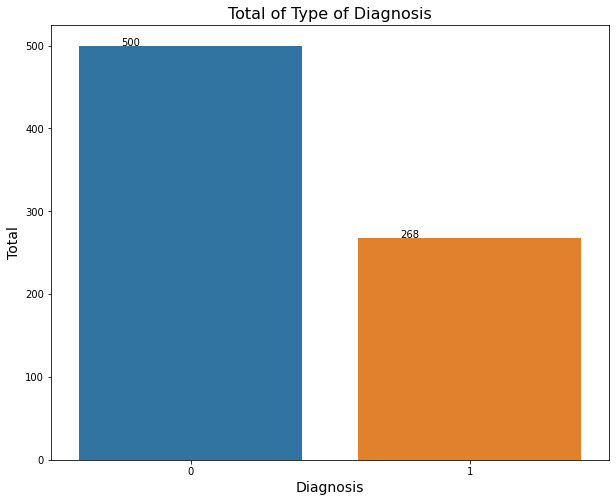

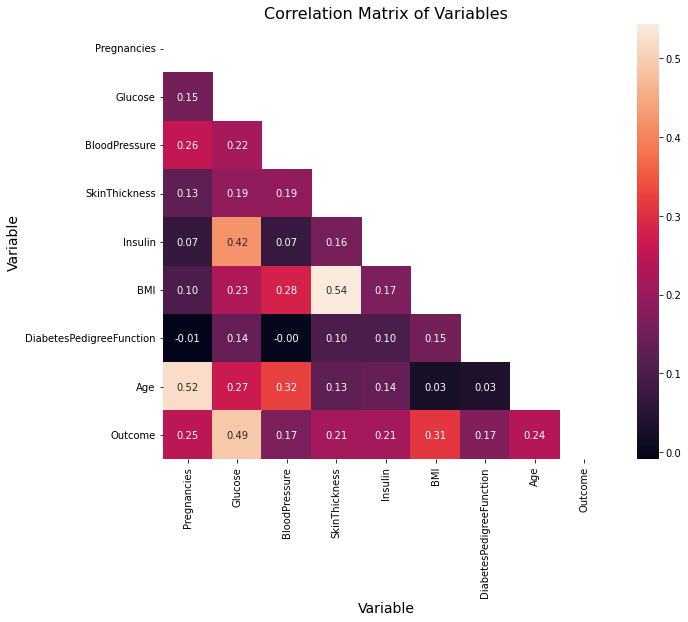

In [ ]:
run_data_analysis()

####12 - Execute the function to tunning and evaluate the Machine Learning method.

Total of Configurations Models: 768


      Model Name Model Alias  Best Params Names Best Params Values  Best Score
0  Random Forest          RF          bootstrap               True    0.767342
1  Random Forest          RF       class_weight               None    0.767342
2  Random Forest          RF          criterion               gini    0.767342
3  Random Forest          RF       max_features               log2    0.767342
4  Random Forest          RF   min_samples_leaf                  5    0.767342
5  Random Forest          RF  min_samples_split                  2    0.767342
6  Random Forest          RF       n_estimators                 15    0.767342
7  Random Forest          RF       random_state                  1    0.767342
8  Random Forest          RF            verbose                  0    0.767342


       Precision  Accuracy     F1  Recall    AUC
Model                                           
RF         0.788     0.797  0.773   0.765  0.765




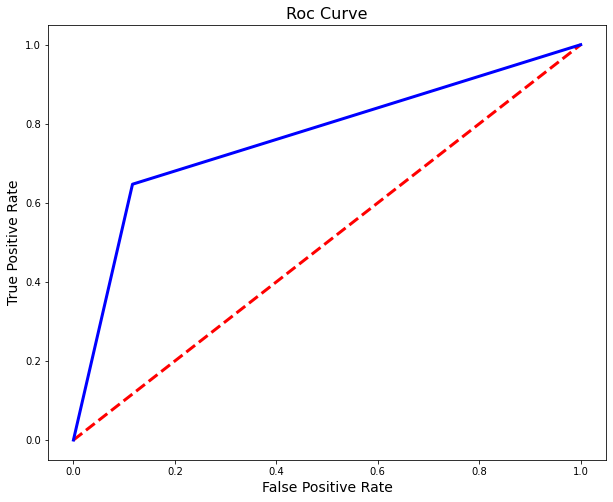

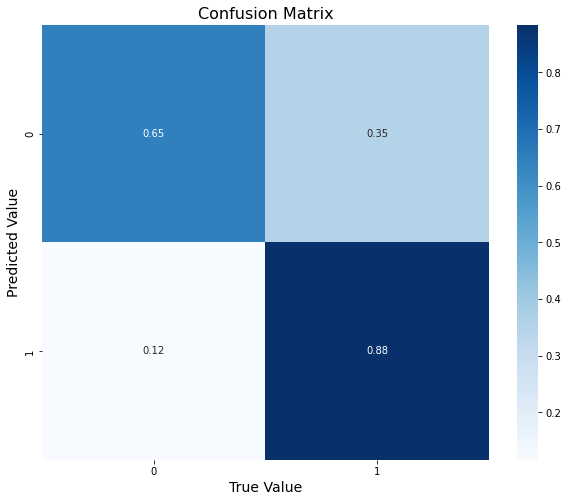

In [ ]:
run_prediction_models(output_path=output_path)